In [294]:
from helper_code import *
import numpy as np, os, sys, joblib
import ecg_plot
import pandas as pd
from glob import glob
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tsai.all import *
import torch
import optuna
from optuna.integration import FastAIPruningCallback
from sklearn.metrics import classification_report
import transformation_funcs as tfs
import seaborn as sns
from torchsummary import summary
torch.cuda.set_device(0) 

In [295]:
def snomedConvert(label_df,snomed=True):
    codes =  pd.read_csv("data/codes.csv",sep=";")[["Dx","SNOMED CT Code"]]
    if snomed:
        label_df.columns = [codes[codes["SNOMED CT Code"] == int(x)]["Dx"].item() for x in label_df.columns]
        return label_df
DATASET_NAME = "WFDB_CPSC2018_signitured"
X = np.load('./data/big_numpy_datasets/%s.npy'%DATASET_NAME, mmap_mode='c')
label_df = pd.read_csv("data/%s.csv"%DATASET_NAME).drop(columns=["headers","leads"])
y = snomedConvert(label_df)


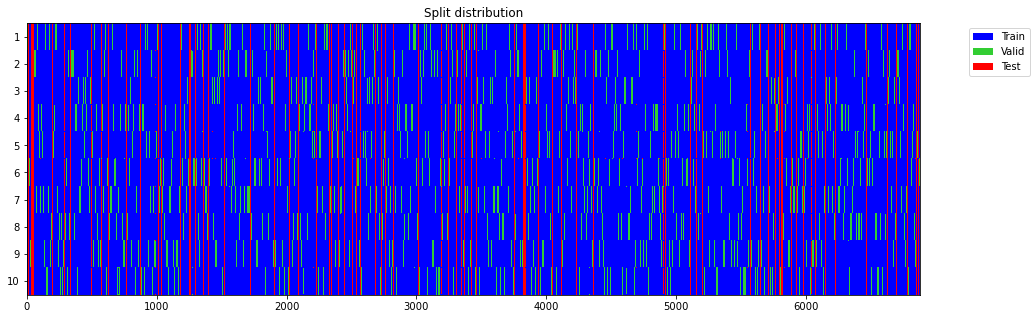

Counts by label: {'right bundle branch block': 1857, 'sinus rhythm': 918, 'atrial fibrillation': 1221, 'ventricular ectopics': 700, 'st depression': 869, 'left bundle branch block': 236, 'st elevation': 220, '1st degree av block': 722, 'premature atrial contraction': 616}


In [296]:

cv_splits = get_splits(y.to_numpy(), n_splits = 10, valid_size=.1,test_size=0.1, stratify=False, random_state=23, shuffle=True)
y_multi = []
for i,row in y.iterrows():
    sample_labels = []
    for i,r in enumerate(row):
        if r == True:
            sample_labels.append(y.columns[i])
        
    y_multi.append(list(tuple(sample_labels)))
label_counts = collections.Counter([a for r in y_multi for a in r])
print('Counts by label:', dict(label_counts))

In [ ]:
max_len = 5000
sf = 0.3
tfms  = [None, TSMultiLabelClassification()]
batch_tfms = [
#              TSStandardize(by_sample=True),
                tfs.Scale(scale_factor=sf,),
                tfs.Normalize(),
                tfs.BandPass(int(sf*500),low_cut=50, high_cut=1,leads=12,),
                tfs.RandomShift(0.1),
#                 tfs.MulNoise(6),
#                 tfs.CutOutWhenTraining(),
             ]
for cv_num in range(5):
#     cv_num = cv_num + 5
    dsets = TSDatasets(X.astype(float)[:,:,0:max_len], y_multi, tfms=tfms, splits=cv_splits[cv_num]) # inplace=True by default
    dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[64, 128], batch_tfms=batch_tfms, num_workers=0)
    metrics =[accuracy_multi, balanced_accuracy_multi, precision_multi, recall_multi, specificity_multi, F1_multi] 
    # model = MiniRocketPlus(dls.vars, dls.c,2500)
    model = InceptionTimePlus(dls.vars, dls.c, dls.len, depth=8,ks = 120 )
    # try : loss_func = BCEWithLogitsLossFlat(pos_weight=dls.train.cws.sqrt())
    
    learn = Learner(dls, model, metrics=metrics,
#                     opt_func = wrap_optimizer(torch.optim.Adam,weight_decay=6.614e-07),
                    cbs=[ShowGraph(),SaveModelCallback(monitor="F1_multi",fname="inception_augmented_%s_%s"%max_len,cv_num)],
                    model_dir="models/10CV/")
    learn.fit_one_cycle(300, lr_max=0.008)
    learn.recorder.plot_metrics()

### check f1s

In [312]:

batch_tfms = [
#              TSStandardize(by_sample=True),
                tfs.Scale(scale_factor=sf,),
                tfs.Normalize(),
                tfs.BandPass(int(sf*500),low_cut=50, high_cut=1,leads=12,),
#                 tfs.RandomShift(0.1),
#                 tfs.MulNoise(6),
#                 tfs.CutOutWhenTraining(),
             ]
reports = []
for cv_num in range(10):
    fold_splits = cv_splits[cv_num]
    dsets = TSDatasets(X.astype(float)[:,:,0:max_len], y_multi, tfms=tfms, splits=(fold_splits[0],fold_splits[2])) # inplace=True by default
    dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[128, 128], batch_tfms=batch_tfms, num_workers=0)
    model = InceptionTimePlus(dls.vars, dls.c, dls.len, depth=8,ks=120)
    learn = Learner(dls, model, metrics=metrics, 
                    cbs=[ShowGraph()],
                    model_dir="models/10CV/")
    learn.load("inception_augmented_%s"%cv_num)
    valid_probas, valid_targets, valid_preds = learn.get_preds(dl=dls.valid, with_decoded=True)

    y_pred = (valid_preds>0)
    y_test = valid_targets

    report = classification_report(y_test, y_pred,target_names = dls.vocab.o2i.keys(),digits=3,output_dict=True)
    reports.append(report)

In [301]:
for report in reports:
    for k,v in report.items():
        report[k] = report[k]["f1-score"]
pd.DataFrame(reports).median()

1st degree av block             0.857143
atrial fibrillation             0.947574
left bundle branch block        0.926829
premature atrial contraction    0.684753
right bundle branch block       0.938615
sinus rhythm                    0.751177
st depression                   0.796537
st elevation                    0.494444
ventricular ectopics            0.787097
micro avg                       0.848566
macro avg                       0.798919
weighted avg                    0.843962
samples avg                     0.820718
dtype: float64

In [306]:
def label_convert(label):
    mapping = {'1st degree av block':"I-AVB",
    'atrial fibrillation':"AF",
    'left bundle branch block':"LBBB",
    'premature atrial contraction':"PAC",
    'right bundle branch block':"RBBB",
    'sinus rhythm':"normal",
    'st depression':"STD",
    'st elevation':"STE",
    'ventricular ectopics':"PVC"}
    try: 
        return mapping[label]
    except:
        return label
df = pd.DataFrame(reports)
df.columns = [label_convert(x) for x in df.columns]
sorted(dict(df[df.columns].median()).items())

[('AF', 0.9475738396624472),
 ('I-AVB', 0.857142857142857),
 ('LBBB', 0.9268292682926829),
 ('PAC', 0.6847527472527473),
 ('PVC', 0.7870967741935484),
 ('RBBB', 0.9386153121565755),
 ('STD', 0.7965372232078323),
 ('STE', 0.49444444444444446),
 ('macro avg', 0.7989188534643077),
 ('micro avg', 0.8485664033055083),
 ('normal', 0.751177394034537),
 ('samples avg', 0.8207180980106743),
 ('weighted avg', 0.8439618361186179)]

In [311]:
winner = dict(zip(["normal","AF","I-AVB","LBBB","RBBB","PAC","PVC","STD","STE"],[0.795,0.897,0.865,0.821,0.911,0.734,0.852,0.788,0.509]))
winner_ensemble = dict(zip(["normal","AF","I-AVB","LBBB","RBBB","PAC","PVC","STD","STE"],[0.808,0.933,0.875,0.884,0.910,0.826,0.869,0.811,0.624]))
inception_no_augment = dict(zip(["RBBB","PVC","AF","LBBB","STE","I-AVB","PAC","normal","STD"],[0.944,0.715,0.939,0.891,0.482,0.833,0.505, 0.709,0.789]))
# inception_augmented = dict(zip(["RBBB","PVC","AF","LBBB","STE","I-AVB","PAC","normal","STD"],[0.935,0.682,0.944,0.884,0.450,0.846,0.474, 0.731,0.778]))
inception_augmented = dict({('AF', 0.9475738396624472),
 ('I-AVB', 0.857142857142857),
 ('LBBB', 0.9268292682926829),
 ('PAC', 0.6847527472527473),
 ('PVC', 0.7870967741935484),
 ('RBBB', 0.9386153121565755),
 ('STD', 0.7965372232078323),
 ('STE', 0.49444444444444446),
 ('normal', 0.751177394034537),})
inception_scaled_only = dict({
                        'I-AVB': 0.8464646464646466,
                         'AF': 0.9429286608260325,
                         'LBBB': 0.8717948717948718,
                         'PAC': 0.454995499549955,
                         'RBBB': 0.9367724233463863,
                         'normal': 0.6970246316758748,
                         'STD': 0.765686274509804,
                         'STE': 0.46785225718194257,
                         'PVC': 0.68630634479812,})
inception_normal_only = dict({
                            'I-AVB': 0.8464646464646466,
                             'AF': 0.9305368413587689,
                             'LBBB': 0.8717948717948718,
                             'PAC': 0.38829471182412356,
                             'RBBB': 0.9354067624592703,
                             'normal': 0.7190058479532164,
                             'STD': 0.7508747606786823,
                             'STE': 0.43843843843843844,
                             'PVC': 0.6731462086300797,
                        })

winner = dict(sorted(winner.items()))
winner_ensemble = dict(sorted(winner_ensemble.items()))
inception = dict(sorted(inception.items()))
inception_augmented = dict(sorted(inception_augmented.items()))
df = pd.DataFrame([winner_ensemble,winner,inception_augmented,inception_scaled_only,inception_normal_only],index=["winner_ensemble","winner","inception_augmented","inception_scaled_only","inception_normal_only"]).T
df["performance"] = df["winner"]<df["inception_augmented"]
df

,winner_ensemble,winner,inception_augmented,inception_scaled_only,inception_normal_only,performance
AF,0.933,0.897,0.947574,0.942929,0.930537,True
I-AVB,0.875,0.865,0.857143,0.846465,0.846465,False
LBBB,0.884,0.821,0.926829,0.871795,0.871795,True
PAC,0.826,0.734,0.684753,0.454995,0.388295,False
PVC,0.869,0.852,0.787097,0.686306,0.673146,False
RBBB,0.910,0.911,0.938615,0.936772,0.935407,True
STD,0.811,0.788,0.796537,0.765686,0.750875,True
STE,0.624,0.509,0.494444,0.467852,0.438438,False
normal,0.808,0.795,0.751177,0.697025,0.719006,False


In [310]:
df.mean()

winner_ensemble          0.837778
winner                   0.796889
inception_augmented      0.798241
inception_scaled_only    0.741092
inception_normal_only    0.728218
performance              0.333333
dtype: float64